Perform statistical aggregaation and produce plots for visual analysis of data.

In [13]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

23/08/19 20:46:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [15]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [16]:
yellow_sdf = spark.read.parquet('../data/curated/yellow_tlc_final/')

In [26]:
#set sample sizes so we know how much data we are using and to ensure graphs and plots are readable. 
sample_size_pandas = 0.005

#sample the spark dataframe into a smaller pandas dataframe for computational ease
yellow_df_sample_pandas = yellow_sdf.sample(sample_size_pandas, seed = 8).toPandas()

print("yellow_df_sample_pandas size:", len(yellow_df_sample_pandas.index))

yellow_df_sample_pandas size: 86484


/home/wconlon28/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/wconlon28/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


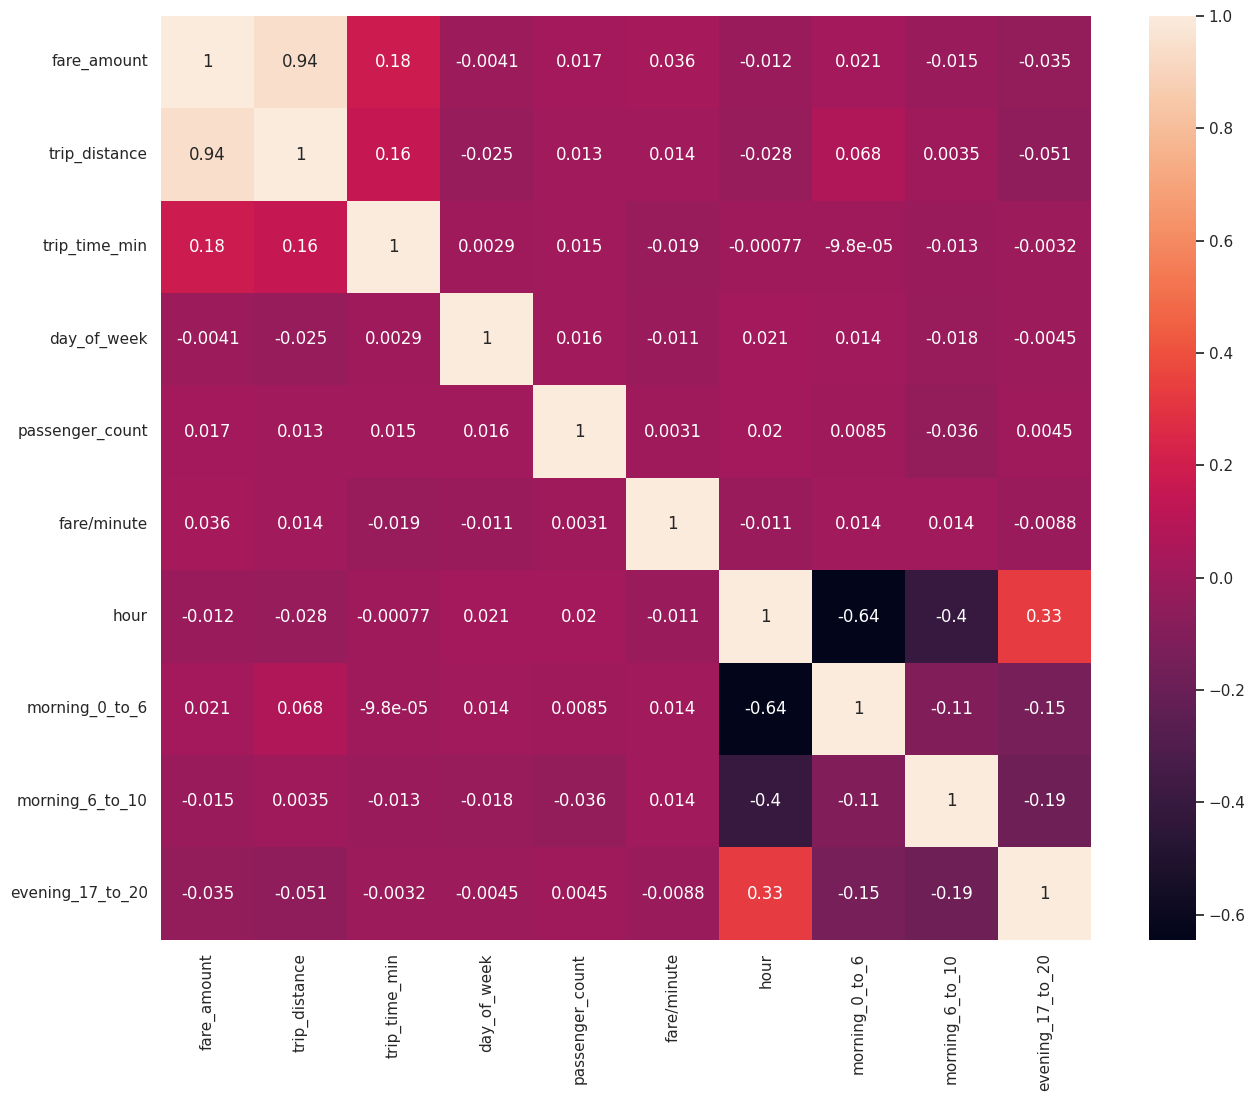

In [34]:
#Create a heat map of the features of interest and our engineered features

compare = yellow_df_sample_pandas[['fare_amount', "trip_distance", 'trip_time_min', "day_of_week", "passenger_count", 'fare/minute',\
                                    'hour', 'morning_0_to_6', 'morning_6_to_10', 'evening_17_to_20']].copy()
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(compare.corr(), annot = True)
plt.savefig('/home/wconlon28/mast30034-project-1-Wconlon28-4/plots/heatmap.PNG')


In [23]:
def retrive_sums (c):
    """This function will find the sums of fares, trip distance and trip time, and 
    sort it aggregate it by the input column c, then return the dataframe of sums."""

    sum_results = yellow_sdf \
                    .groupBy(c) \
                    .agg(
                        F.sum("fare_amount").alias("Total Fare Amount USD"),
                        F.sum("trip_distance").alias("Total Trip Distance Miles"),
                        F.sum("trip_time_min").alias("Total Trip Time Minutes")
                    ) \
                    .orderBy(c)
    
    return sum_results

In [10]:
""""Retrive the sums of fares, trip distance and trip time according to the specified input column and makinfg them pandas 
dataframes to be visualised in Matplot.lib"""

date_sums = retrive_sums("trip_date").toPandas()#This is sums by date, i.e 2022-07-01, 2022-07-02, ...

weekend_sums = retrive_sums("is_weekend").toPandas()

day_sums = retrive_sums("day_of_week").toPandas() #this is sums by day, i.e Monday, Tuesday, ...

airport_sums = retrive_sums("airport_fee").toPandas()

passenger_sums = retrive_sums('passenger_count').toPandas()

hour_sums = retrive_sums("hour").toPandas()

pickup_sums = retrive_sums("pulocationid").toPandas()

dropoff_sums = retrive_sums("dolocationid").toPandas()

/home/wconlon28/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


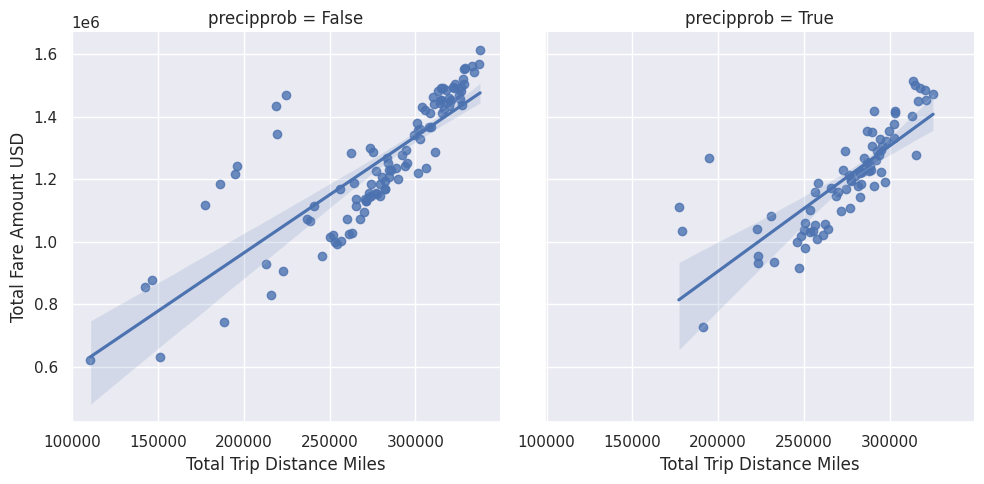

In [31]:
#loadf theweather data
weather_df = pd.read_csv("../data/landing/weather_clean")

#adjoin the weather data and the sums by date as they have the same size
weather_date_df = pd.concat([weather_df, date_sums], axis = 1)

#ensure all Totals are above a threshold for better visualisation
weather_date_df = weather_date_df[weather_date_df["Total Fare Amount USD"]>1000]

#plot two different plots by whether ir rained as total trip miles vs the total fare amounts for each day since they will ahave a linear relationship the diseribution will be easy to see
sns.lmplot(x = 'Total Trip Distance Miles', y = 'Total Fare Amount USD', col = 'precipprob', data = weather_date_df)
plt.savefig('/home/wconlon28/mast30034-project-1-Wconlon28-4/plots/rain_plot')

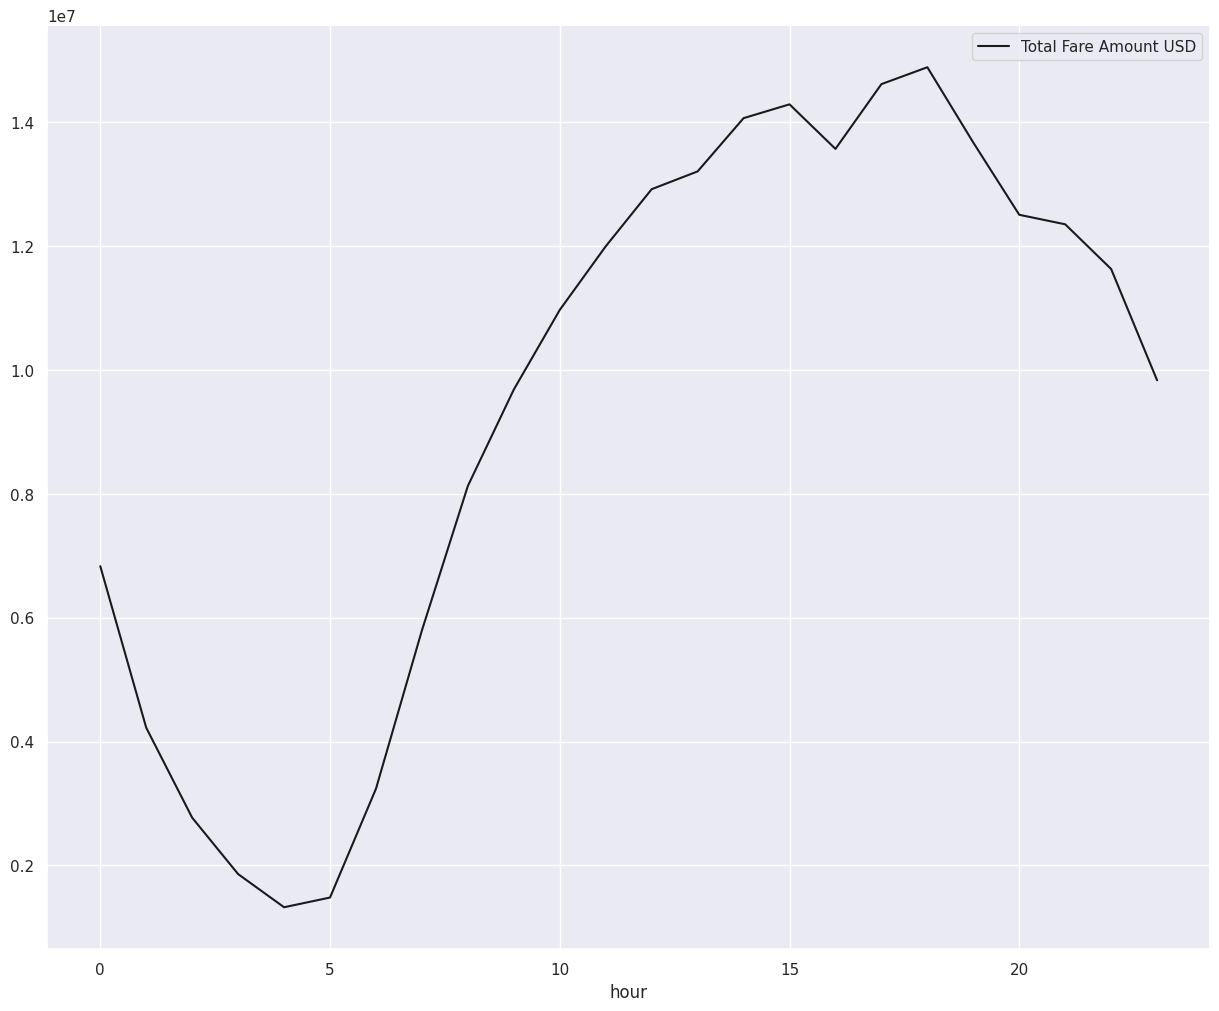

In [30]:
#plot the toal fare amount by what hour of the day it was
hour_sums.plot(x = 'hour', y = 'Total Fare Amount USD',c = "k")
plt.savefig("/home/wconlon28/mast30034-project-1-Wconlon28-4/plots/hour_plot")

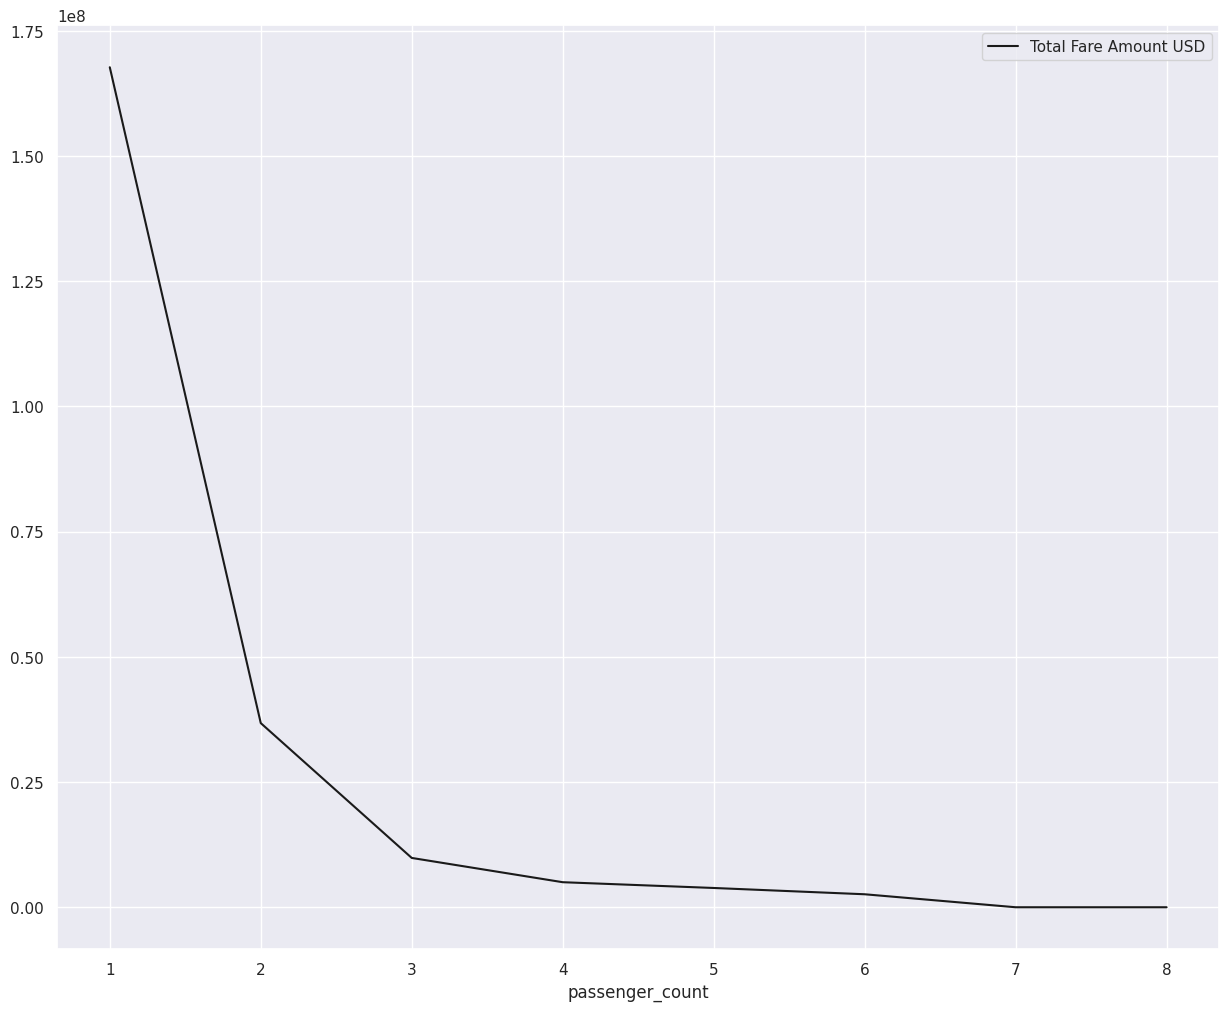

In [29]:
#plot the total amount of the fare against the number of passengers in that trip
passenger_sums.plot(x = 'passenger_count', y = 'Total Fare Amount USD',c = "k")
plt.savefig("/home/wconlon28/mast30034-project-1-Wconlon28-4/plots/passenger_plot")

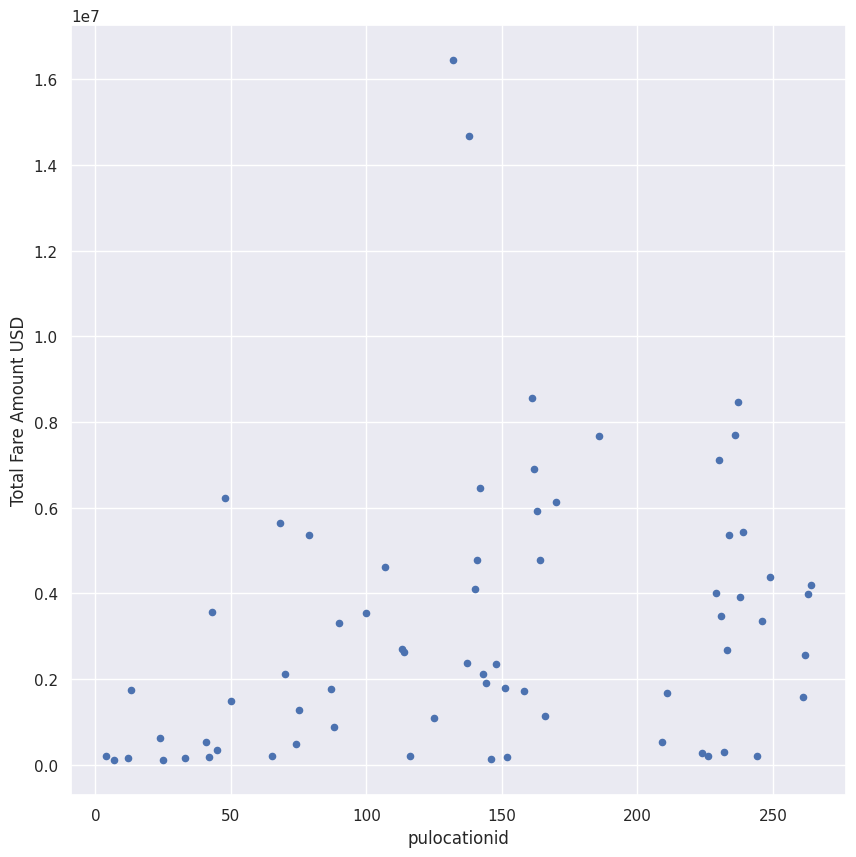

In [ ]:
#plot the pickup location id against the total fare amount of that location 

#filter fare sums so they are greatr than $100,000 USD to only see the best ones. 
pickup_sums = pickup_sums[pickup_sums["Total Fare Amount USD"]> 100000] 

pickup_sums.plot.scatter(x = 'pulocationid', y = 'Total Fare Amount USD')

plt.savefig("/home/wconlon28/mast30034-project-1-Wconlon28-4/plots/pickup_plot")


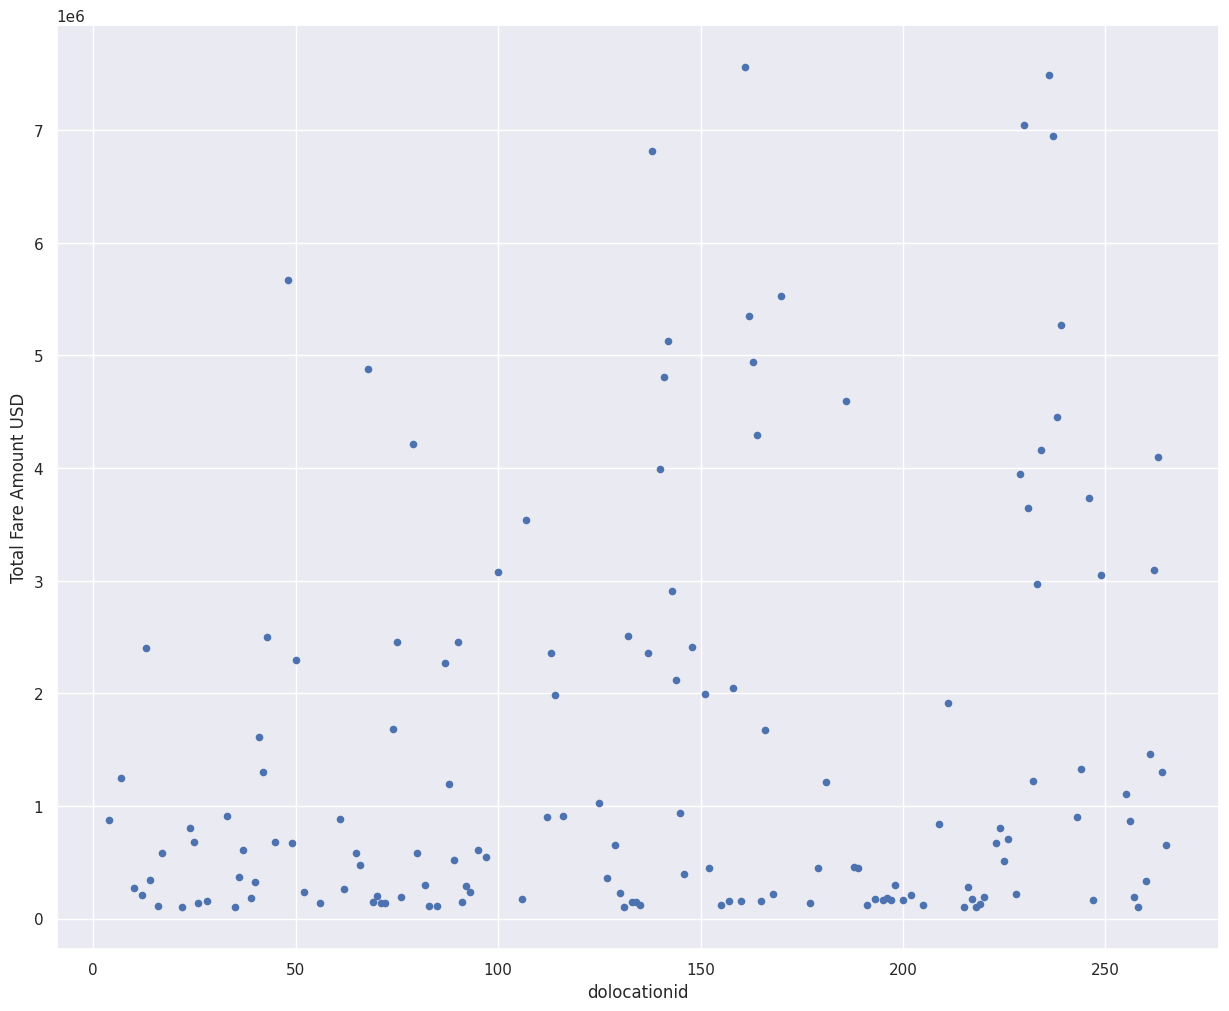

In [33]:
#plot the drop off location id against the total fare amount of that location 

#filter fare sums so they are greatr than $100,000 USD to only see the best ones. 
dropoff_sums = dropoff_sums[dropoff_sums["Total Fare Amount USD"]> 100000] 

dropoff_sums.plot.scatter(x = 'dolocationid', y = 'Total Fare Amount USD')

plt.savefig("/home/wconlon28/mast30034-project-1-Wconlon28-4/plots/dropoff_plot")

In [ ]:
#find the top 5 fare sums by pickup location id
pickup_sums.sort_values(by = ['Total Fare Amount USD']).tail(5)

,pulocationid,Total Fare Amount USD,Total Trip Distance Miles,Total Trip Time Minutes
231,236,7705187.33,1487171.74,1.001338e+07
232,237,8464411.29,1564673.91,1.113696e+07
157,161,8569345.71,1666687.24,1.168351e+07
134,138,14670198.49,4557926.59,1.470193e+07
128,132,16445861.36,5554118.85,1.568694e+07


In [ ]:
#find the top 5 fare sums by drop off location id
dropoff_sums.sort_values(by = ['Total Fare Amount USD']).tail(5)

,dolocationid,Total Fare Amount USD,Total Trip Distance Miles,Total Trip Time Minutes
134,138,6811847.68,2160002.38,6.429290e+06
232,237,6944563.60,1230089.54,9.178279e+06
225,230,7045543.90,1402822.80,9.902098e+06
231,236,7485278.21,1485147.23,9.414751e+06
157,161,7558494.83,1366039.78,1.038993e+07
